In [12]:
! pip install numpy
! pip install svgwrite

In [13]:
import svgwrite
from svgwrite.text import Text
from IPython.display import SVG, display
import numpy as np
from itertools import combinations
import math
import os

In [14]:
import svgwrite

def make_collage(svgs, cell_width, cell_height, n_cols=5, margin=10, background_color="white"):
    """
    Create a collage of SVGs arranged in a grid.
    
    Parameters:
    - svgs: List of svgwrite.Drawing objects (same size)
    - cell_width, cell_height: Dimensions of each individual SVG
    - n_cols: Number of columns in the collage grid
    - margin: Margin between images
    - background_color: Optional background fill

    Returns:
    - svgwrite.Drawing collage
    """
    n_rows = (len(svgs) + n_cols - 1) // n_cols
    total_width = n_cols * cell_width + (n_cols - 1) * margin
    total_height = n_rows * cell_height + (n_rows - 1) * margin

    collage = svgwrite.Drawing(size=(total_width, total_height))

    # Optional: background
    if background_color:
        collage.add(collage.rect(insert=(0, 0),
                                 size=(total_width, total_height),
                                 fill=background_color))

    for idx, drawing in enumerate(svgs):
        col = idx % n_cols
        row = idx // n_cols
        x = col * (cell_width + margin)
        y = row * (cell_height + margin)

        # Extract inner SVG elements from the original drawing
        for elem in drawing.elements:
            # Clone and translate
            g = collage.g(transform=f"translate({x},{y})")
            g.add(elem.copy())
            collage.add(g)

    return collage


# Triangulations

In [15]:
def regular_polygon_vertices(n, radius=100, center=(120, 120)):
    """Return the vertices of a regular n-gon."""
    cx, cy = center
    return [
        (
            cx + radius * math.cos(2 * math.pi * i / n - math.pi / 2),
            cy + radius * math.sin(2 * math.pi * i / n - math.pi / 2)
        )
        for i in range(n)
    ]

def unique_triangulations(n):
    """Compute unique triangulations (modulo triangle reuse)."""
    from functools import lru_cache

    @lru_cache(None)
    def triangulate(start, end):
        if end - start < 2:
            return [[]]
        res = []
        for k in range(start+1, end):
            for left in triangulate(start, k):
                for right in triangulate(k, end):
                    res.append(left + right + [[start, k, end]])
        return res

    return triangulate(0, n-1)



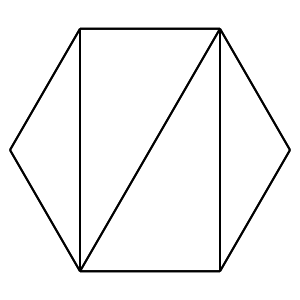

In [16]:
import svgwrite
from IPython.display import SVG, display

def regular_polygon_vertices_horizontal(n, radius=1.0, center=(0, 0)):
    """Generate vertices of a regular polygon, special case for n=6 to align top/bottom"""
    cx, cy = center
    return [
        (cx + radius * math.cos(2 * math.pi * i / n),
            cy + radius * math.sin(2 * math.pi * i / n))
        for i in range(n)
    ]

def draw_svg_triangulation(n, triangles, size=(300, 300), margin=10):
    dwg = svgwrite.Drawing(size=size)
    radius = (min(size) - 2 * margin) / 2
    center = (size[0] / 2, size[1] / 2)
    vertices = regular_polygon_vertices_horizontal(n, radius, center)

    # Draw polygon edges
    for i in range(n):
        a, b = vertices[i], vertices[(i + 1) % n]
        dwg.add(dwg.line(a, b, stroke="black", stroke_width=2))

    # Draw triangulation edges
    for tri in triangles:
        for i in range(3):
            a, b = vertices[tri[i]], vertices[tri[(i + 1) % 3]]
            dwg.add(dwg.line(a, b, stroke="black", stroke_width=2))

    # for i, (x, y) in enumerate(regular_polygon_vertices_horizontal(n, radius+15, center)):
    #     dwg.add(Text(str(i), insert=(x, y), font_size="30px", fill="black"))
    #     dwg.add(dwg.circle(center=(x, y), r=2, fill="red"))

    return dwg

# Example usage:
n = 6
triangles = unique_triangulations(n)[1]  # pick first triangulation
svg = draw_svg_triangulation(n, triangles)
display(SVG(svg.tostring()))
svg.saveas("catalan_triangulation.svg")


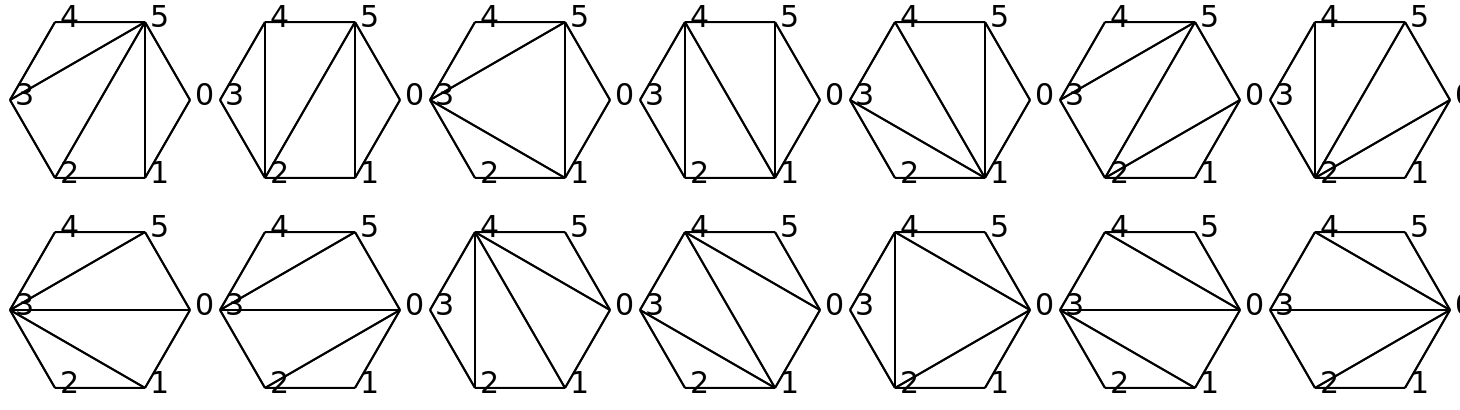

In [17]:
def draw_svg_collage(min_n=3, max_n=6, cell_size=(300, 300), padding=10, per_row=4):
    from math import ceil

    all_triangulations = []
    for n in range(min_n, max_n + 1):
        ts = unique_triangulations(n)
        for t in ts:
            all_triangulations.append((n, t))

    cols = per_row
    rows = ceil(len(all_triangulations) / cols)
    width = cols * (cell_size[0] + padding) - padding
    height = rows * (cell_size[1] + padding) - padding

    dwg = svgwrite.Drawing(size=(width, height))

    for idx, (n, triangles) in enumerate(all_triangulations):
        row = idx // cols
        col = idx % cols
        offset_x = col * (cell_size[0] + padding)
        offset_y = row * (cell_size[1] + padding)

        radius = (min(cell_size) - 20) / 2
        center = (offset_x + cell_size[0] / 2, offset_y + cell_size[1] / 2)
        vertices = regular_polygon_vertices_horizontal(n, radius, center)

        # Draw polygon outline
        for i in range(n):
            a, b = vertices[i], vertices[(i + 1) % n]
            dwg.add(dwg.line(a, b, stroke="black", stroke_width=2))

        # Draw triangle edges
        for tri in triangles:
            for i in range(3):
                a, b = vertices[tri[i]], vertices[tri[(i + 1) % 3]]
                dwg.add(dwg.line(a, b, stroke="black", stroke_width=2))

        for i, (x, y) in enumerate(vertices):
            dwg.add(Text(str(i), insert=(x + 5, y + 5), font_size="30px", fill="black"))

    return dwg

# Example usage
svg_collage = draw_svg_collage(min_n=6, max_n=6, cell_size=(200, 200), per_row=7)
display(SVG(svg_collage.tostring()))
svg_collage.saveas("catalan_triangulations.svg")


# Grid walks

In [18]:
import svgwrite
from IPython.display import SVG, display

def draw_grid_walk_svg(moves, cell_size=40, with_diagonal=True, with_highlight=True, with_second_diagonal=False, num_moves=None, with_upper_diagonal=False, with_mirror_path=False, margin=15, num_mirror_moves=None):
    width = moves.count('R')
    height = moves.count('U')
    size = max(width, height)

    dwg = svgwrite.Drawing(size=(cell_size*(size) + 2*margin, cell_size*(size) + 2*margin), fill='none')
    
    # Draw arrows
    arrow = dwg.marker(id='arrow', insert=(2, 3), size=(10, 10), orient="auto")
    #arrow.add(dwg.path(d="M0,0 L10,3 L0,6 L2,3 Z", fill="black"))
    arrow.add(dwg.path(d="M0,0 L6,3 L0,6 Z", fill="black"))
    dwg.defs.add(arrow)
    arrow_style = {'stroke': 'black', 'stroke_width': 3, 'marker_end': 'url(#arrow)'}

    def draw_square(x, y, fill):
        dwg.add(dwg.rect(insert=(margin + x*cell_size, margin + (size-y)*cell_size),
                        size=(cell_size, cell_size),
                        fill=fill, stroke='black', stroke_width=1))
    
    def draw_arrow(x0, y0, x1, y1):
        dwg.add(dwg.line(start=(margin + (x0)*cell_size, margin +(size-y0)*cell_size),
                         end=(margin + (x1)*cell_size, margin +(size-y1)*cell_size),
                         **arrow_style))
    
    # Draw grid
    for x in range(size):
        for y in range(1, size+1):
            draw_square(x, y, 'lightcyan')
   
    # Trace path and collect filled cells
    x, y = 0, 0
    path = [(x, y)]
    mirror_path = [(x-1, y+1)]
    for m in moves:
        if m == 'R':
            x += 1
        elif m == 'U':
            y += 1
        path.append((x, y))
        mirror_path.append((y-1, x+1))  # Mirror path for upper diagonal

    if num_moves is not None:
        path = path[:num_moves + 1]  # Include the starting point

    if num_mirror_moves is not None:
        mirror_path = mirror_path[:num_mirror_moves + 1]
    #Highlight area under the path
    if with_highlight:
        for i in range(1, len(path)):
            x0, y0 = path[i-1]
            x1, y1 = path[i]
            if x1 != x0:  # horizontal move
                for k in range(y1):
                    draw_square(x0, k+1, 'peachpuff')

    for (x0, y0), (x1, y1) in zip(path[:-1], path[1:]):
        draw_arrow(x0, y0, x1, y1)

    if with_mirror_path:
        for (x0, y0), (x1, y1) in zip(mirror_path[:-1], mirror_path[1:]):
            draw_arrow(x0, y0, x1, y1)

    # Draw diagonal
    if with_diagonal:
        dwg.add(dwg.line(start=(margin, margin + size*cell_size), end=(margin + size*cell_size, margin),
                     stroke='black', stroke_dasharray="5,5", stroke_width=2))
        
    if with_second_diagonal:
        dwg.add(dwg.line(start=(cell_size + margin, margin + size*cell_size), end=(margin + size*cell_size, margin+cell_size),
                     stroke='black', stroke_dasharray="5,5", stroke_width=2))
    
    if with_upper_diagonal:
        dwg.add(dwg.line(start=(margin, margin + size*cell_size - cell_size), end=(margin + size*cell_size - cell_size, margin),
                     stroke='black', stroke_dasharray="5,5", stroke_width=2))

    return dwg


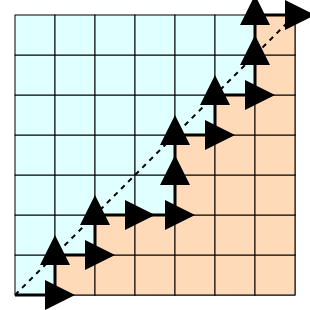

In [19]:
# Example
moves = "RURURRUURURUUR"
svg = draw_grid_walk_svg(moves)
display(SVG(svg.tostring()))
svg.saveas("grid_walk_wrong.svg")

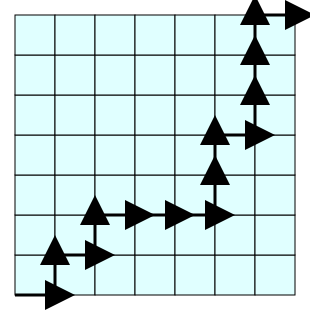

In [20]:
moves = "RURURRRUURUUUR"
svg = draw_grid_walk_svg(moves, with_diagonal=False, with_highlight=False)
display(SVG(svg.tostring()))
svg.saveas("grid_walk_basic.svg")

In [21]:
# # Example
# moves = "RRURURUURURURU"
# svg = draw_grid_walk_svg(moves, num_moves=1, with_highlight=False)
# svg.saveas("grid_walk_example_1.svg")
# svg = draw_grid_walk_svg(moves, with_second_diagonal=True, num_moves=8)
# svg.saveas("grid_walk_example_2.svg")
# svg = draw_grid_walk_svg(moves, with_second_diagonal=True)
# svg.saveas("grid_walk_example_3.svg")
# display(SVG(svg.tostring()))

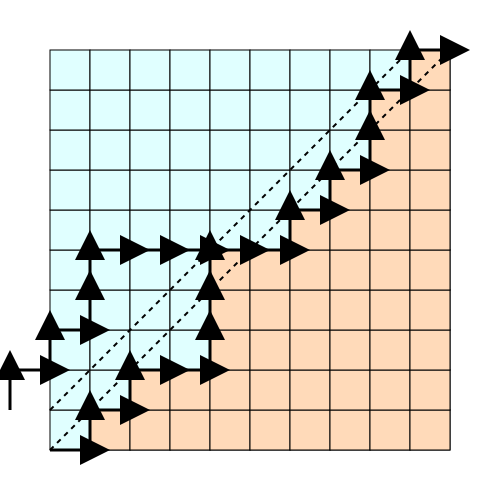

In [22]:

moves = "RURURRUUURRURURUURUR"
svg = draw_grid_walk_svg(moves)
# svg.saveas("grid_walk_mirror_1.svg")
svg = draw_grid_walk_svg(moves, with_upper_diagonal=True, with_mirror_path=True, margin=50, num_mirror_moves=9)
# svg.saveas("grid_walk_mirror_2.svg")
display(SVG(svg.tostring()))

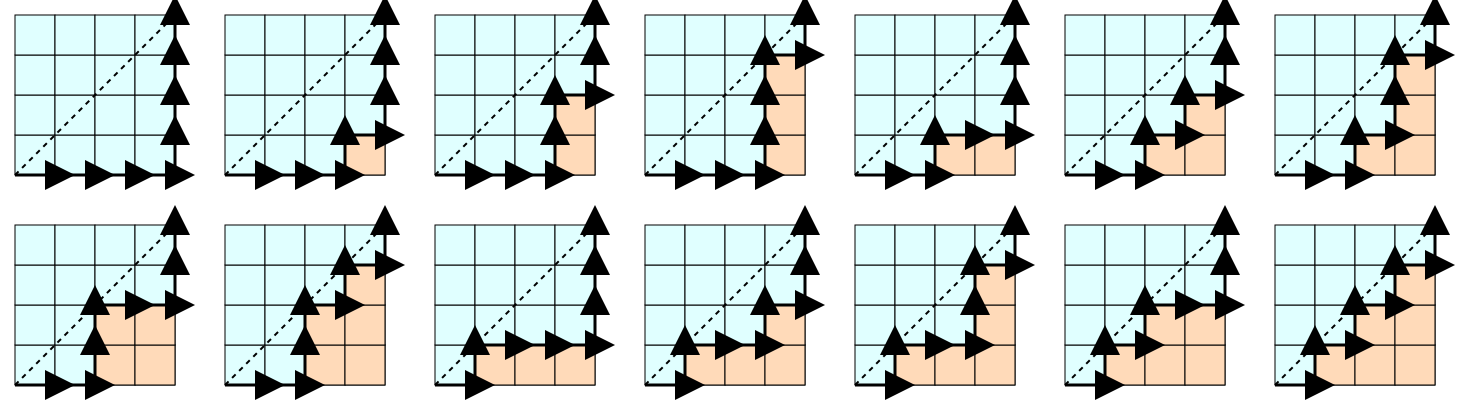

In [23]:
def generate_balanced_dyck_strict(n):
    results = []

    def backtrack(s, r_count, u_count):
        if len(s) == 2 * n:
            if r_count == u_count:
                results.append(s)
            return
        # Add R if we haven't used all R's
        if r_count < n:
            backtrack(s + 'R', r_count + 1, u_count)
        # Add U if:
        # 1. We haven't used all U's
        # 2. Number of R's > U's (strict)
        if u_count < n and r_count > u_count:
            backtrack(s + 'U', r_count, u_count + 1)

    backtrack("", 0, 0)
    return results

# Generate all strict Dyck strings of length 8 (4 R, 4 U)
strings = generate_balanced_dyck_strict(4)
images = [draw_grid_walk_svg(moves) for moves in strings]
collage = make_collage(images, cell_width=200, cell_height=200, n_cols=7, margin=10)
display(SVG(collage.tostring()))
collage.saveas("grid_walks_4.svg")

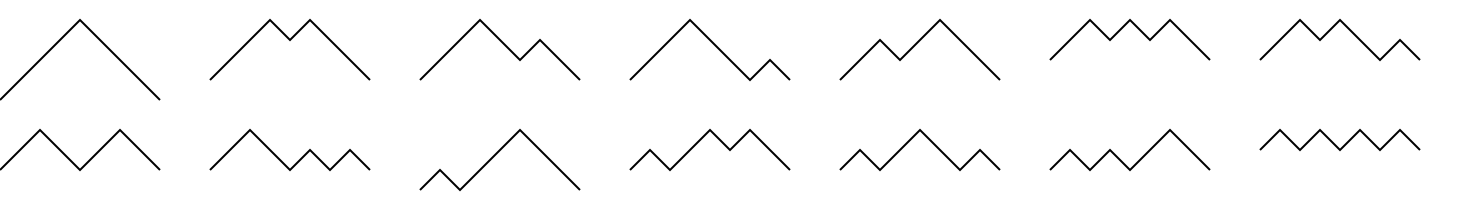

In [24]:
import svgwrite

def draw_dyck_svg(word, dx=20, dy=20, stroke_color="black", stroke_width=2):
    """
    Draw a Dyck path SVG from a word of R (up-right) and U (down-right).
    """
    # Track path points
    points = [(0, 0)]
    x, y = 0, 0

    for ch in word:
        x += dx
        y += -dy if ch == 'R' else dy
        points.append((x, y))

    # Determine SVG size
    min_y = min(y for _, y in points)
    max_y = max(y for _, y in points)
    width = x + dx
    height = max_y - min_y + 2 * dy

    # Offset vertically to make all y positive
    y_offset = -min_y + dy

    dwg = svgwrite.Drawing(size=(width, height))
    path = dwg.polyline([(x, y + y_offset) for x, y in points],
                        fill='none', stroke=stroke_color, stroke_width=stroke_width)
    dwg.add(path)

    return dwg

strings = generate_balanced_dyck_strict(4)
images = [draw_dyck_svg(moves) for moves in strings]
collage = make_collage(images, cell_width=200, cell_height=100, n_cols=7, margin=10)
display(SVG(collage.tostring()))
collage.saveas("dyck_paths_4.svg")
# # Example usage:
# dyck_word = "RRURURUU"  # You can replace this with any Dyck path
# dwg = draw_dyck_svg(dyck_word)
# display(SVG(dwg.tostring()))


# Trees

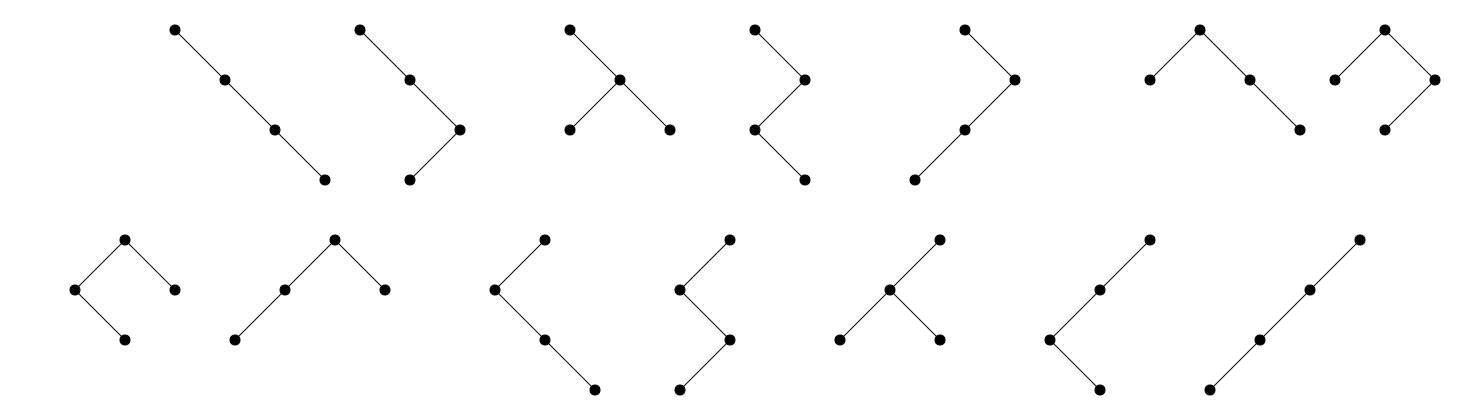

In [25]:
def generate_binary_trees(n):
    """
    Generate all binary trees with n internal nodes.
    Each tree is represented as nested tuples: ('node', left, right)
    Leaves are None.
    """
    if n == 0:
        return [None]  # A leaf

    trees = []
    for left_nodes in range(n):
        right_nodes = n - 1 - left_nodes
        for left in generate_binary_trees(left_nodes):
            for right in generate_binary_trees(right_nodes):
                trees.append(['node', left, right])
    return trees

import svgwrite

def draw_binary_tree(tree, node_radius=5, x_spacing=50, y_spacing=50, margin=30, with_labels=False):
    """
    Draw a binary tree (nested tuple format) as an SVG using svgwrite.
    Returns an svgwrite.Drawing object.
    """
    # First pass: compute coordinates
    positions = {}

    def assign_positions(node, depth, width=0):
        if node is None:
            return
        assign_positions(node[1], depth + 1, width - 1)  # left
        x = width * x_spacing + margin
        y = depth * y_spacing + margin
        positions[id(node)] = (x, y)
        assign_positions(node[2], depth + 1, width + 1 )  # right

    assign_positions(tree, 0)

    # Compute canvas size
    width = max((x for x, y in positions.values()), default=0) + x_spacing + margin*2
    height = max((y for x, y in positions.values()), default=0) + y_spacing + margin*2
    positions = {k: (v[0] + width // 2, v[1]) for k, v in positions.items()}
    dwg = svgwrite.Drawing(size=(2*width, height))

    # Second pass: draw nodes and edges
    def draw_node(node):
        if node is None:
            return
        x, y = positions[id(node)]
        dwg.add(dwg.circle(center=(x, y), r=node_radius, fill='black', stroke='black'))
        dwg.add(dwg.text("•", insert=(x, y + 4), text_anchor="middle", font_size="14px"))
        if with_labels:
            dwg.add(dwg.text(str(node[0]), insert=(x, y - 10), text_anchor="middle", font_size="14px"))

        for child in [node[1], node[2]]:
            if child is not None:
                cx, cy = positions[id(child)]
                dwg.add(dwg.line(start=(x, y), end=(cx, cy), stroke='black'))
                draw_node(child)

    draw_node(tree)
    return dwg

trees = generate_binary_trees(4)
images = [draw_binary_tree(tree) for tree in trees]
collage = make_collage(images, cell_width=200, cell_height=200, n_cols=7, margin=10)
display(SVG(collage.tostring()))
collage.saveas("binary_trees_4.svg")



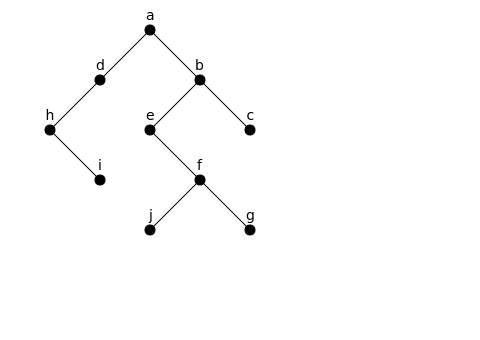

In [26]:
def count_nodes(tree):
    """
    Count the number of nodes in a binary tree.
    """
    if tree is None:
        return 0
    return 1 + count_nodes(tree[1]) + count_nodes(tree[2])

def label_tree(tree, labels=None):
    """
    Label a binary tree with given labels.
    If labels are not provided, use default labels.
    """
    if labels is None:
        labels = [str(i) for i in range(count_nodes(tree))]

    def assign_labels(node, idx=0):
        if node is None:
            return idx
        node[0] = labels[idx]
        idx = assign_labels(node[1], idx + 1)
        return assign_labels(node[2], idx)

    assign_labels(tree)
    return tree

tree = ['a', 
        ['d', ['h', None, ['i', None, None]], None],
        ['b', ['e', None, ['f', ['j', None, None], ['g', None, None]]], ['c', None, None]],
        ]  # Example tree with one node
# trees = [label_tree(t) for t in generate_binary_trees(6)]
# # for t in trees:
# #     print(t)
draw_binary_tree(tree, with_labels=True)

['a', ['d', ['h', None, ['i', None, None]], None], ['b', ['e', None, ['f', ['j', None, None], ['g', None, None]]], ['c', None, None]]]
['', [['a', [['d', [['h', []], ['i', []]]]]], ['b', [['e', []], ['f', [['j', []]]], ['g', []]]], ['c', []]]]
[[''], ['a', 'b', 'c'], ['d', 'e', 'f', 'g'], ['h', 'i', 'j']]


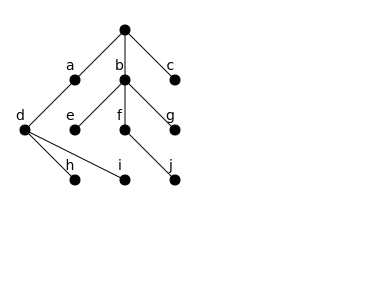

In [27]:
def binary_tree_to_plane_tree(tree, root_name=''):
    root = [root_name,[]]
    if tree is None:
        return root
    node = tree
    while True:
        subtree = binary_tree_to_plane_tree(node[1], node[0])
        root[1].append(subtree)
        if node[2] is None:
            break
        node = node[2]
    return root

def unfold_plane_tree(tree, depth=0, unfolded=None):
    if unfolded is None:
        unfolded = []
    if tree is None:
        return unfolded
    while len(unfolded) <= depth:
        unfolded.append([])
    unfolded[depth].append(tree[0])
    for child in tree[1]:
        unfold_plane_tree(child, depth + 1, unfolded)
    return unfolded

def draw_plane_tree(tree, node_radius=5, x_spacing=50, y_spacing=50, margin=30, with_labels=True):
    # First pass: compute coordinates
    positions = {}

    unfolded = unfold_plane_tree(tree)
    # Assign positions based on depth and index
    for depth, nodes in enumerate(unfolded):
        for width, node in enumerate(nodes):
            if node is None:
                continue
            x = (width - len(nodes) // 2) * x_spacing + margin
            y = depth * y_spacing + margin
            positions[id(node)] = (x, y)

    # Compute canvas size
    width = max((x for x, y in positions.values()), default=0) + x_spacing + margin*2
    height = max((y for x, y in positions.values()), default=0) + y_spacing + margin*2
    positions = {k: (v[0] + width // 2, v[1]) for k, v in positions.items()}
    dwg = svgwrite.Drawing(size=(2*width, height))

    # Second pass: draw nodes and edges
    def draw_node(node):
        if node is None:
            return
        x, y = positions[id(node[0])]
        dwg.add(dwg.circle(center=(x, y), r=node_radius, fill='black', stroke='black'))
        dwg.add(dwg.text("•", insert=(x, y + 4), text_anchor="middle", font_size="14px"))
        if with_labels:
            dwg.add(dwg.text(str(node[0]), insert=(x-5, y - 10), text_anchor="middle", font_size="14px"))

        for child in node[1]:
            if child is not None:
                cx, cy = positions[id(child[0])]
                dwg.add(dwg.line(start=(x, y), end=(cx, cy), stroke='black'))
                draw_node(child)

    draw_node(tree)
    return dwg


print(tree)
plane_tree = binary_tree_to_plane_tree(tree)
print(plane_tree)
unfolded = unfold_plane_tree(plane_tree)
print(unfolded)
draw_plane_tree(plane_tree)

#draw_binary_tree(plane_tree, with_labels=True)

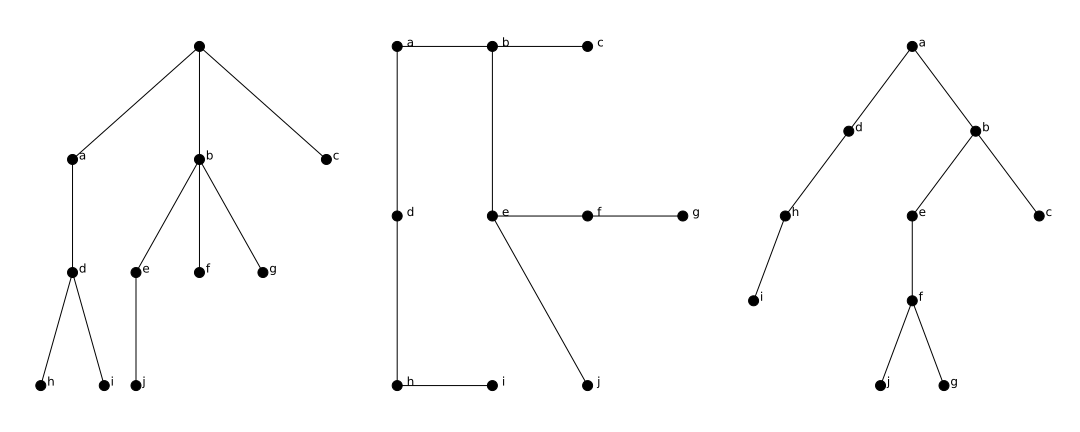

In [28]:
import matplotlib.pyplot as plt
import networkx as nx
import io

# Create the three graphs described in the image
graphs = []

# First graph (left tree)
G1 = nx.DiGraph()
G1_edges = [
    ('r', 'a'), ('r', 'b'), ('r', 'c'),
    ('a', 'd'), ('d', 'h'), ('d', 'i'),
    ('b', 'e'), ('b', 'f'), ('b', 'g'), ('e', 'j')
]
G1.add_edges_from(G1_edges)
G1_pos = {
    'r': (0, 4),
    'a': (-2, 3), 'b': (0, 3), 'c': (2, 3),
    'd': (-2, 2), 'e': (-1, 2), 'f': (0, 2), 'g': (1, 2),
    'h': (-2.5, 1), 'i': (-1.5, 1), 'j': (-1, 1)
}
G1_labels = {k: k for k in G1.nodes if k != 'r'}
graphs.append((G1, G1_pos, G1_labels))

# Second graph (middle Hasse-like diagram)
G2 = nx.DiGraph()
G2_edges = [
    ('a', 'b'), ('b', 'c'),
    ('a', 'd'), ('d', 'h'), ('h', 'i'),
    ('b', 'e'), ('e', 'f'), ('f', 'g'), ('e', 'j')
]
G2.add_edges_from(G2_edges)
G2_pos = {
    'a': (0, 3), 'b': (1, 3), 'c': (2, 3),
    'd': (0, 2), 'e': (1, 2), 'f': (2, 2), 'g': (3, 2),
    'h': (0, 1), 'i': (1, 1), 'j': (2, 1)
}
G2_labels = {k: k for k in G2.nodes}
graphs.append((G2, G2_pos, G2_labels))

# Third graph (right tree)
G3 = nx.DiGraph()
G3_edges = [
    ('a', 'd'), ('a', 'b'), ('b', 'c'),
    ('d', 'h'), ('h', 'i'),
    ('b', 'e'), ('e', 'f'), ('f', 'j'), ('f', 'g')
]
G3.add_edges_from(G3_edges)
G3_pos = {
    'a': (2, 4),
    'd': (1, 3), 'b': (3, 3),
    'h': (0, 2), 'e': (2, 2), 'c': (4, 2),
    'i': (-0.5, 1), 'f': (2, 1),
    'j': (1.5, 0), 'g': (2.5, 0)
}
G3_labels = {k: k for k in G3.nodes}
graphs.append((G3, G3_pos, G3_labels))

# Draw all graphs
fig, axes = plt.subplots(1, 3, figsize=(15, 6))
for ax, (G, pos, labels) in zip(axes, graphs):
    nx.draw(G, pos, ax=ax, with_labels=False, arrows=False, node_size=100, node_color='black')
    for node, (x, y) in pos.items():
        if node in labels:
            ax.text(x + 0.1, y, labels[node], fontsize=12)
    ax.set_axis_off()

plt.tight_layout()
svg_buffer = io.StringIO()
fig.savefig(svg_buffer, format='svg')
plt.close(fig)
svg_output = svg_buffer.getvalue()

# Display the SVG in notebook
svg_image = SVG(svg_output)
display(svg_image)
with open("trees_bijaction_diragram.svg", "w", encoding="utf-8") as f:
    f.write(svg_output)


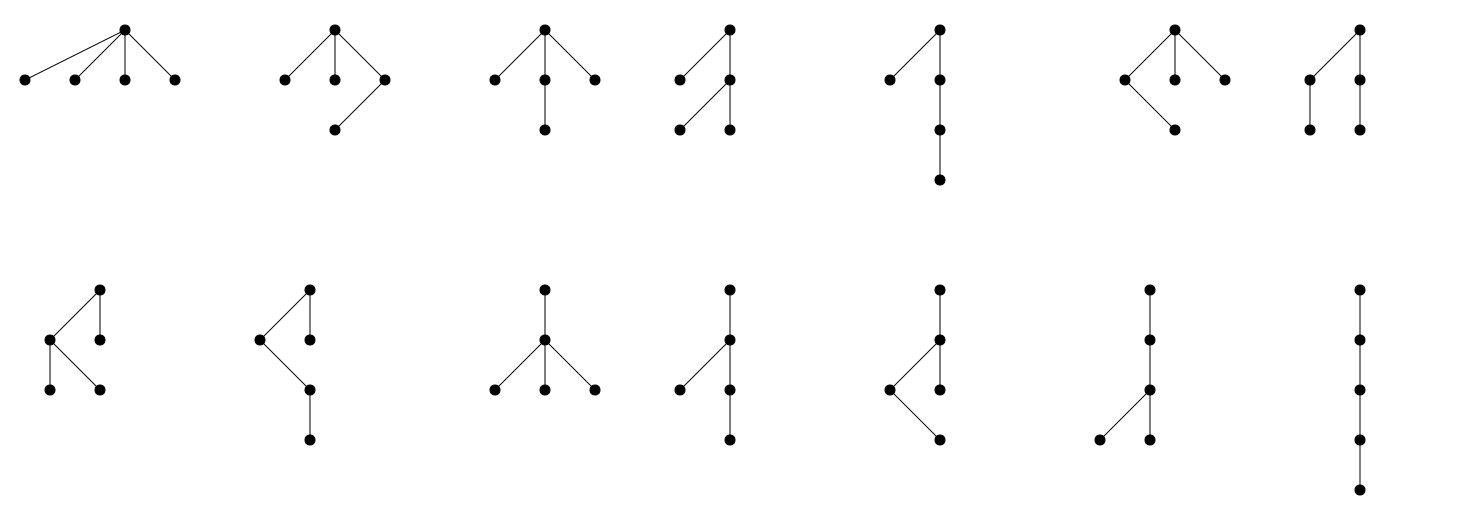

In [29]:
trees = generate_binary_trees(4)
images = []
for t in trees:
    t = label_tree(t, labels=['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j'])
    p_t = binary_tree_to_plane_tree(t)
    images.append(draw_plane_tree(p_t, with_labels=False))
collage = make_collage(images, cell_width=200, cell_height=250, n_cols=7, margin=10)
display(SVG(collage.tostring()))
collage.saveas("plane_trees_4.svg")
    

In [154]:
def generate_dyck_words(n, symbols = ('(', ')')):
    """
    Generate all Dyck words of length 2n using '(' and ')'.
    """
    results = []

    def backtrack(s='', open=0, close=0):
        if len(s) == 2 * n:
            results.append(s)
            return
        if open < n:
            backtrack(s + symbols[0], open + 1, close)
        if close < open:
            backtrack(s + symbols[1], open, close + 1)

    backtrack()
    return results

def dyck_to_plane_tree(dyck_word):
    """
    Convert a Dyck word to a plane tree (nested list format).
    Each node is a list of children.
    """
    stack = []
    root = []
    current = root

    for ch in dyck_word:
        if ch == '(':
            new_node = []
            current.append(new_node)
            stack.append(current)
            current = new_node
        else:  # ')'
            current = stack.pop()

    return root[0]  # root is a dummy list with one tree in it

def draw_plane_tree(tree, x_spacing=20, y_spacing=50, node_radius=8):
    """
    Draw a plane tree (nested list format).
    """
    positions = {}
    counter = [0]  # horizontal in-order counter

    def assign_positions(node, depth):
        cx = counter[0] * x_spacing
        cy = depth * y_spacing
        positions[id(node)] = (cx, cy)
        counter[0] += 1
        for child in node:
            assign_positions(child, depth + 1)

    assign_positions(tree, 0)

    width = max((x for x, y in positions.values()), default=0) + x_spacing
    height = max((y for x, y in positions.values()), default=0) + y_spacing
    dwg = svgwrite.Drawing(size=(width, height))

    def draw_node(node):
        x, y = positions[id(node)]
        dwg.add(dwg.circle(center=(x, y), r=node_radius, fill='lightgreen', stroke='black'))
        for child in node:
            cx, cy = positions[id(child)]
            dwg.add(dwg.line(start=(x, y), end=(cx, cy), stroke='black'))
            draw_node(child)

    draw_node(tree)
    return dwg

In [31]:
dycks = generate_dyck_words(4)
trees = [dyck_to_plane_tree(d) for d in dycks]
images = [draw_plane_tree(tree) for tree in trees]
collage = make_collage(images, cell_width=300, cell_height=300, n_cols=7, margin=10)
#display(SVG(collage.tostring()))

for t in trees:
    print(t)
    

[[[[]]]]
[[[], []]]
[[[]], []]
[[[]]]
[[], [[]]]
[[], [], []]
[[], []]
[[]]
[[]]
[]
[]
[]
[]
[]


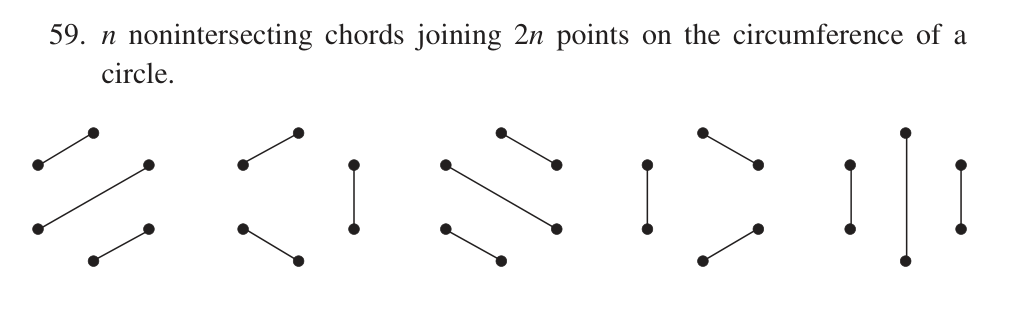

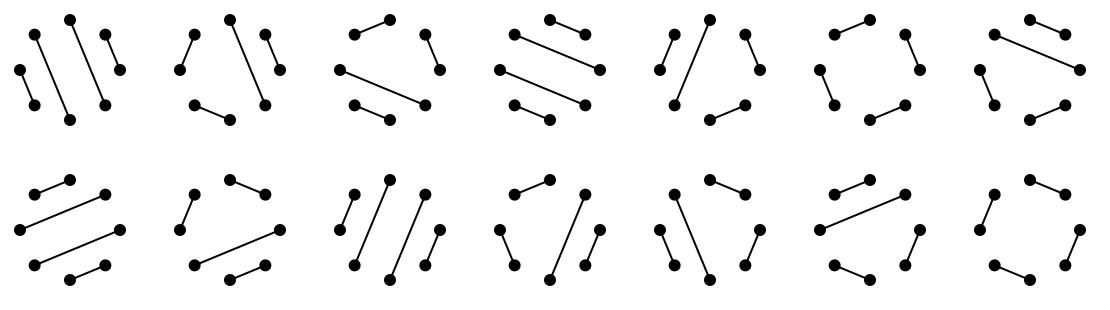

In [32]:
def draw_nonintersecting_chords(n, chords, radius=50, point_radius=6, filename=None):
    dwg = svgwrite.Drawing(size=(2*radius + 40, 2*radius + 40))
    center = (radius + 20, radius + 20)
    #dwg.add(dwg.circle(center=center, r=radius, fill='none', stroke='black', stroke_width=2))
    # Compute positions of 2n points evenly spaced on a circle
    points = [
        (
            center[0] + radius * math.cos(2 * math.pi * i / (2 * n)),
            center[1] + radius * math.sin(2 * math.pi * i / (2 * n))
        )
        for i in range(2 * n)
    ]
    
    # Draw points
    for p in points:
        dwg.add(dwg.circle(center=p, r=point_radius, fill='black'))
    
    # Draw chords
    for i, j in chords:
        dwg.add(dwg.line(start=points[i], end=points[j], stroke='black', stroke_width=2))

    if filename:
        dwg.saveas(filename)
    return dwg

def dyck_word_to_chords(dyck_word):
    """
    Convert a Dyck word to a list of non-intersecting chords.
    Each '(' corresponds to an opening chord, and each ')' to a closing chord.
    """
    stack = []
    chords = []

    for i, ch in enumerate(dyck_word):
        if ch == '(':
            stack.append(i)
        else:  # ')'
            start = stack.pop()
            chords.append((start, i))

    return chords

n = 4
chords = [dyck_word_to_chords(word) for word in generate_dyck_words(n)]
images = [draw_nonintersecting_chords(n, c) for c in chords]

collage = make_collage(images, cell_width=150, cell_height=150, n_cols=7, margin=10)
display(SVG(collage.tostring()))
collage.saveas("nonintersecting_chords_4.svg")
# example_chords = [(0, 5), (1, 2), (3, 4)]
# drawing = draw_nonintersecting_chords(3, example_chords)
# display(SVG(drawing.tostring()))

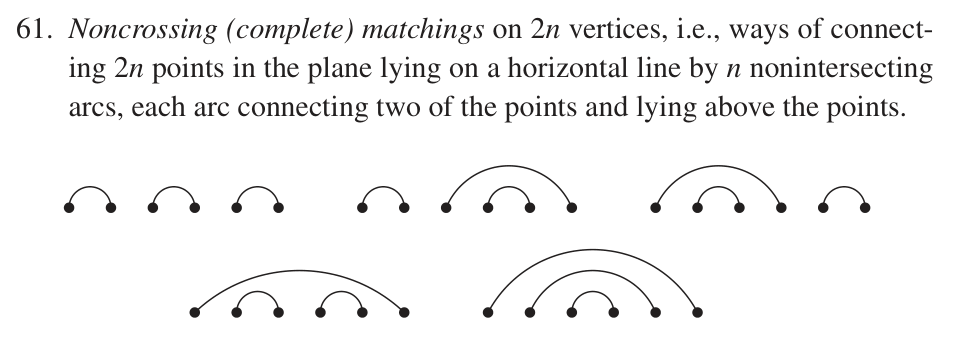

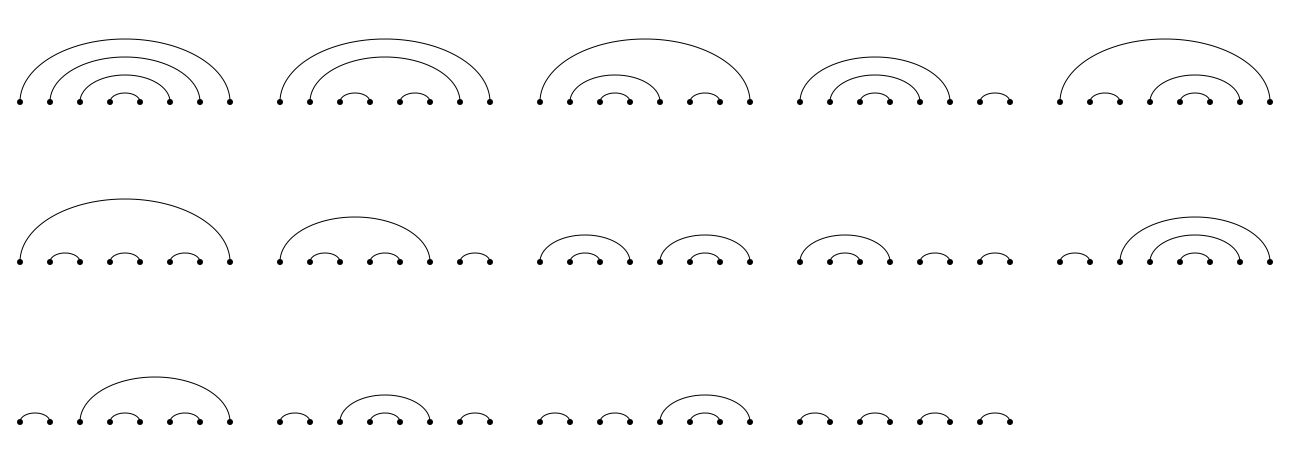

In [33]:
def draw_noncrossing_arcs(n, arcs, spacing=30, arc_height_factor=0.6, point_radius=3, with_labels = False, filename=None):
    width = spacing * (2 * n - 1) + 40
    height = int(spacing * n * arc_height_factor) + 60
    baseline_y = height - 30
    dwg = svgwrite.Drawing(size=(width, height))
    
    # Compute x-positions of 2n points
    points = [(20 + i * spacing, baseline_y) for i in range(2 * n)]

    # Track parentheses to place under each point
    labels = [""] * (2 * n)
    for i, j in arcs:
        if i < j:
            labels[i] = "("
            labels[j] = ")"
        else:
            labels[j] = "("
            labels[i] = ")"

    # Draw base points and labels
    for idx, (x, y) in enumerate(points):
        dwg.add(dwg.circle(center=(x, y), r=point_radius, fill='black'))
        if with_labels and labels[idx]:
            dwg.add(dwg.text(labels[idx], insert=(x, y + 15), text_anchor="middle", font_size="14px"))

    # Draw arcs
    for i, j in arcs:
        if i > j:
            i, j = j, i
        x1, x2 = points[i][0], points[j][0]
        radius_x = abs(x2 - x1) / 2
        radius_y = radius_x * arc_height_factor
        path = f"M{x1},{baseline_y} A{radius_x},{radius_y} 0 0,1 {x2},{baseline_y}"
        dwg.add(dwg.path(d=path, fill='none', stroke='black'))

    if filename:
        dwg.saveas(filename)
    return dwg

n = 4
chords = [dyck_word_to_chords(word) for word in generate_dyck_words(n)]
images = [draw_noncrossing_arcs(n, c) for c in chords]

collage = make_collage(images, cell_width=250, cell_height=150, n_cols=5, margin=10)
display(SVG(collage.tostring()))
#collage.saveas("nonintersecting_arcs_4.svg")


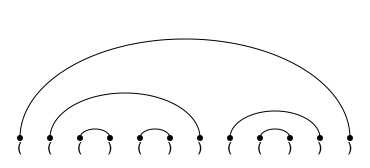

In [34]:
word = '((()())(()))'
n = len(word) // 2
chords = dyck_word_to_chords(word)
drawing = draw_noncrossing_arcs(n, chords, with_labels=True)
display(SVG(drawing.tostring()))
drawing.saveas("nonintersecting_arcs_example.svg")

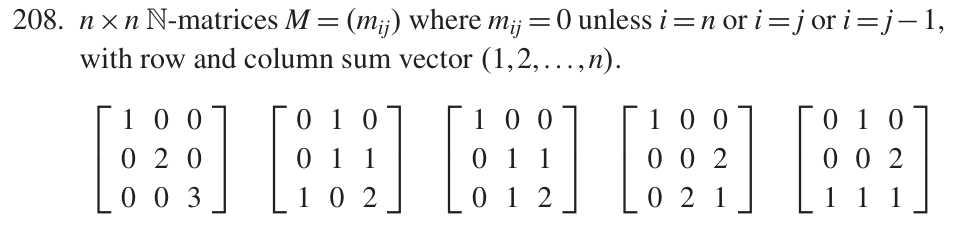

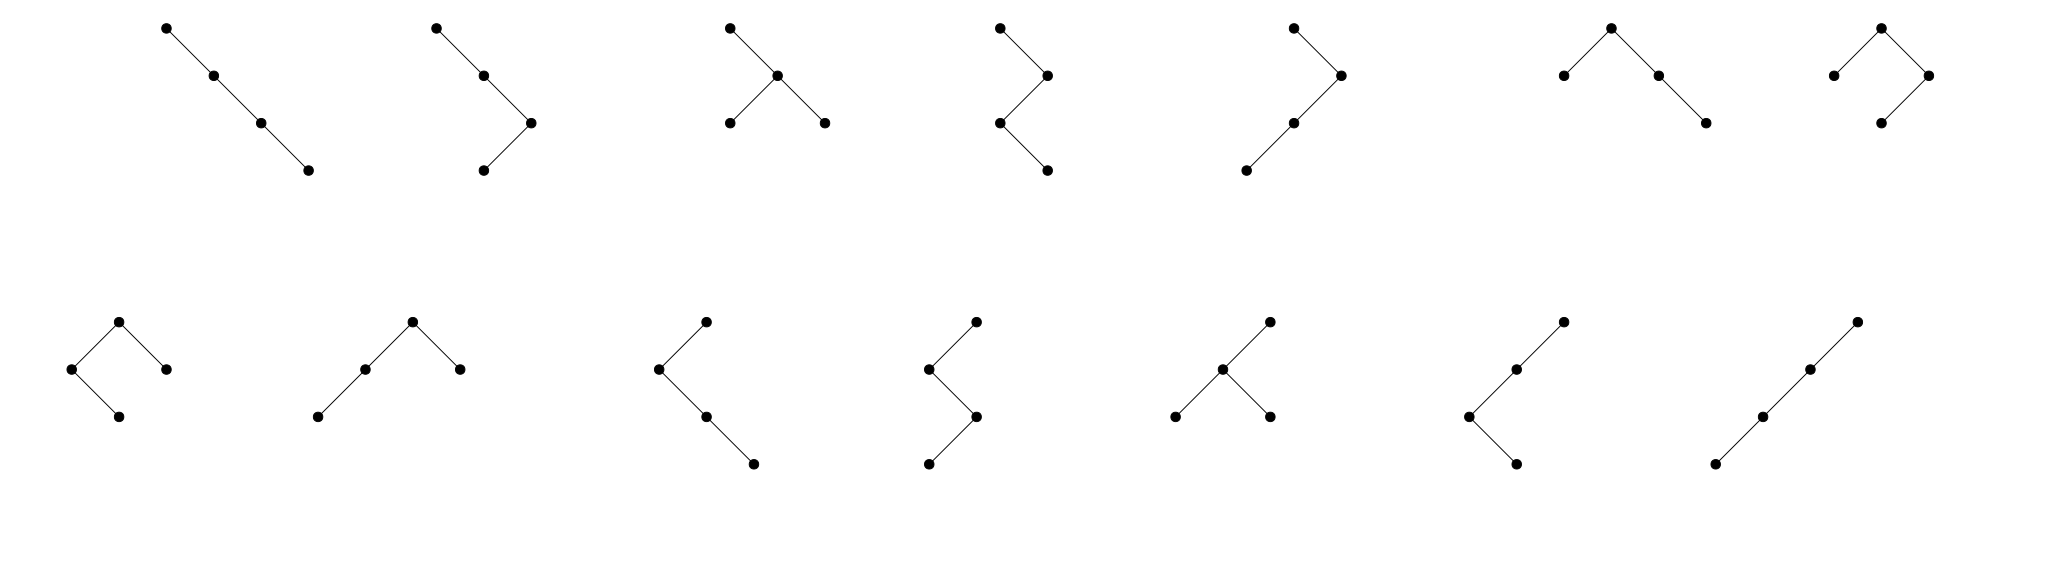

In [35]:
trees = generate_binary_trees(4)
images = [draw_binary_tree(tree) for tree in trees]
collage = make_collage(images, cell_width=300, cell_height=300, n_cols=7, margin=10)
display(SVG(collage.tostring()))

# Kepler towers

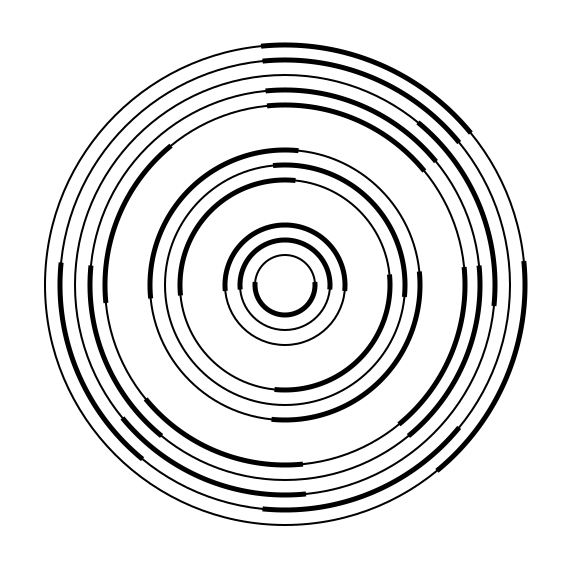

In [363]:
import svgwrite
import math

def arc_path(cx, cy, r, start_angle, end_angle):
    """Returns an SVG arc path string from angle1 to angle2 at radius r centered at (cx, cy)"""
    x1 = cx + r * math.cos(start_angle)
    y1 = cy + r * math.sin(start_angle)
    x2 = cx + r * math.cos(end_angle)
    y2 = cy + r * math.sin(end_angle)
    large_arc = 1 if end_angle - start_angle > math.pi else 0
    return f"M{x1},{y1} A{r},{r} 0 {large_arc},1 {x2},{y2}"

def draw_kepler_tower_segmented(wall_data, base_radius=30, ring_gap=15, wall_gap=30):
    """
    wall_data: list of walls, where each wall is a list of rings (bottom to top),
               and each ring is a list of segment indices (1-based)
    """
    num_walls = len(wall_data)
    num_rings = sum([len(wall) for wall in wall_data])
       
    # cx, cy = 300, 300

    max_radius = base_radius + 30 + (num_walls - 1) * wall_gap + num_rings * ring_gap
    cx, cy = max_radius,  max_radius
    dwg = svgwrite.Drawing(size=(2*cx, 2*cy))
    stroke_width = 5
    extra_angle = 0.1

    current_radius = base_radius

    for wall_index, wall in enumerate(wall_data):
        num_segments = 2**(wall_index + 1)
        delta_theta = 2 * math.pi / num_segments
        for ring in wall:
            dwg.add(dwg.circle(center=(cx, cy), r=current_radius, fill='none', stroke='black', stroke_width=2))
            for seg in ring:
                start_angle = seg * delta_theta
                end_angle = (seg + 1) * delta_theta
                path_d = arc_path(cx, cy, current_radius, start_angle - extra_angle, end_angle + extra_angle)
                dwg.add(dwg.path(d=path_d, stroke='black', fill='none', stroke_width=stroke_width))
            current_radius += ring_gap  # move outward for next ring
        current_radius += wall_gap
    return dwg

wall_data = [
    [ [0], [1], [1] ],                             
    [ [0,2], [3], [0,2] ],                         
    [ [0,2,4,6], [0,3,6], [2,7], [1,3,6], [0,6]]
]


tower = draw_kepler_tower_segmented(wall_data)
display(SVG(tower.tostring()))
tower.saveas("kepler_tower_example.svg")


In [293]:
import random

def random_dyck_word(n):
    if n % 2 != 0:
        raise ValueError("Dyck words must have even length")

    def generate(u, d, word):
        if len(word) == n:
            return word
        choices = []
        if u < n // 2:
            choices.append(('U', u + 1, d))
        if d < u:
            choices.append(('D', u, d + 1))
        c, new_u, new_d = random.choice(choices)
        return generate(new_u, new_d, word + c)

    return generate(0, 0, '')

[(60, 0), (100, 0), (140, 0), (180, 1), (260, 3), (320, 2), (340, 3), (420, 1), (460, 1), (500, 1), (520, 2), (540, 3), (600, 1), (740, 5), (820, 3), (840, 4), (880, 4), (900, 5)]


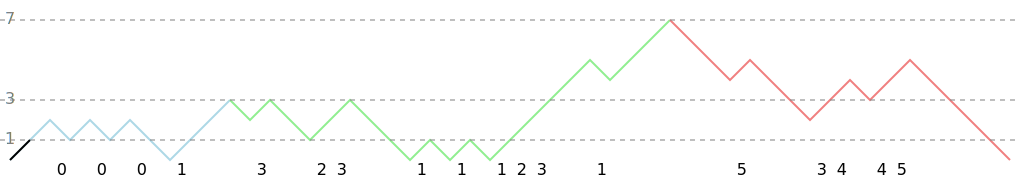

In [ ]:
def add_split_line(dwg, height, width, label, color="gray"):
    y = height  # SVG y-axis goes *down*, so y is height in your coordinates

    # Add dashed horizontal line across the whole drawing
    dwg.add(dwg.line(start=(0, y), end=(width, y),
                     stroke=color, stroke_dasharray="5,5", stroke_width=1))

    # Add label to the left of the line
    dwg.add(dwg.text(str(label),
                     insert=(5, y + 4),  # adjust position to align with line
                     text_anchor="start",
                     font_size="16px",
                     fill=color))
    
def draw_dyck_split(word, dx=20, dy=20, stroke_width=2, x_margin=10, with_bricks=False):
    """
    Draw a Dyck path SVG from a word of R (up-right) and U (down-right).
    """
    # Track path points
    current_height = 0
    current_border = 0
    wall_points = [[(0, 0)]]
    x, y = 0, 0
    bricks = []
    for ch in word:
        x += dx
        y += -dy if ch == 'U' else dy
        current_height += 1 if ch == 'U' else -1
        wall_points[-1].append((x, y))

        if current_height <= current_border and ch == 'U':
            bricks.append((x, current_height))
        if current_height >= current_border and ch == 'D':
            bricks.append((x, current_height-current_border))
        
        if current_height == current_border*2 + 1:
            current_border = current_height
        k = len(wall_points)
        if current_height >= 2**(k+1)-1:
            wall_points.append([(x, y)])

    # Determine SVG size
    min_y = min(y for _, y in [p for points in wall_points for p in points])
    max_y = max(y for _, y in [p for points in wall_points for p in points])
    width = x + dx
    height = max_y - min_y + 2 * dy

    # Offset vertically to make all y positive
    y_offset = -min_y + dy

    dwg = svgwrite.Drawing(size=(width, height))
    colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightpink']
    for i, points in enumerate(wall_points):
        color = colors[i % len(colors)]
        path = dwg.polyline([(x+x_margin, y + y_offset) for x, y in points], stroke=color, stroke_width=stroke_width, fill='none')
        dwg.add(path)
    
    # the first step is special and should be colorless
    path = dwg.polyline([(x+x_margin, y + y_offset) for x, y in wall_points[0][:2]], stroke='black', stroke_width=stroke_width, fill='none')
    dwg.add(path)

    for k in range(len(wall_points)):
        h = 2**(k+1) - 1
        add_split_line(dwg, height=height - (h+1) * dy, width=width, label=f"{h}")
    print(bricks)
    if with_bricks:
        for x, val in bricks:
            dwg.add(dwg.text(str(val), insert=(x + dx/3 + x_margin-20, y_offset+15),
                     text_anchor="start",
                     font_size="16px",
                     fill='black'))
    return dwg

[(220, 2), (240, 1), (260, 0)]


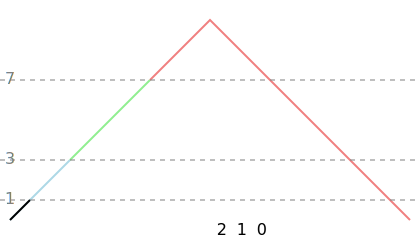

[[[0]], [[0, 2]], [[0, 2, 4, 6], [2], [1], [0]]]


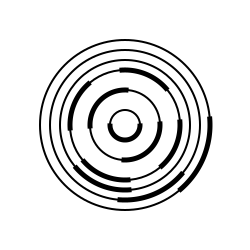

In [ ]:
def add_brick(wall, s, n):
    m = len(wall) - 1
    while not (s in wall[m] or (s+1) % n in wall[m] or (s-1) % n in wall[m]):
        m -= 1
    if m == len(wall) - 1: # new ring
        wall.append([])
    wall[m+1].append(s)
     
def generate_kepler_tower_from_dyck(word):
    tower = []
    height = 0
    for ch in word:
        k = len(tower)
        current_border = 2**k-1
        next_border = 2**(k+1)-1
        height += 1 if ch == 'U' else -1
        if height >= current_border and ch == 'D':
            add_brick(tower[-1], height - current_border, 2**k)
        if height <= current_border and ch == 'U':
            add_brick(tower[-1], height, 2**k)
        if height == next_border:
            new_wall = [[2*i for i in range(2**k)]]
            tower.append(new_wall)
    return tower

#word = random_dyck_word(50)
# word = "UUDUDUDDUUUDUDDUUDDDUDUDUUUUUDUUUDDDUDDDUUDUUDDDDD"
tower = [[[0]], [[0, 2]], [[0, 2, 4, 6], [2], [1], [0]]]
word = generate_dyck_from_kepler(tower)
# word = "UUUUUUUUUUDDDDDDDDDD"
image = draw_dyck_split(word, with_bricks=True)
display(SVG(image.tostring()))
tower = generate_kepler_tower_from_dyck(word)
kepler_image = draw_kepler_tower_segmented(tower, base_radius=15, ring_gap=10, wall_gap=10)
# kepler_image.saveas("kepler_tower_from_dyck.svg")
print(tower)
display(SVG(kepler_image.tostring()))

[(60, 0), (100, 0), (140, 0), (180, 1), (260, 3), (320, 2), (340, 3), (420, 1), (460, 1), (500, 1), (520, 2), (540, 3), (600, 1), (740, 5), (820, 3), (840, 4), (880, 4), (900, 5)]


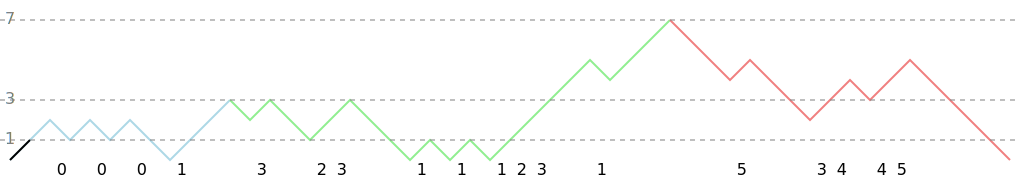

In [353]:

word = "UUDUDUDDUUUDUDDUUDDDUDUDUUUUUDUUUDDDUDDDUUDUUDDDDD"
image = draw_dyck_split(word, with_bricks=True)
display(SVG(image.tostring()))
image.saveas("dyck_split_with_nums.svg")

[[[0], [0], [0], [0], [1]], [[0, 2], [3], [2], [3, 1], [1], [1], [2], [3, 1]], [[0, 2, 4, 6], [5, 3], [4], [4], [5]]]


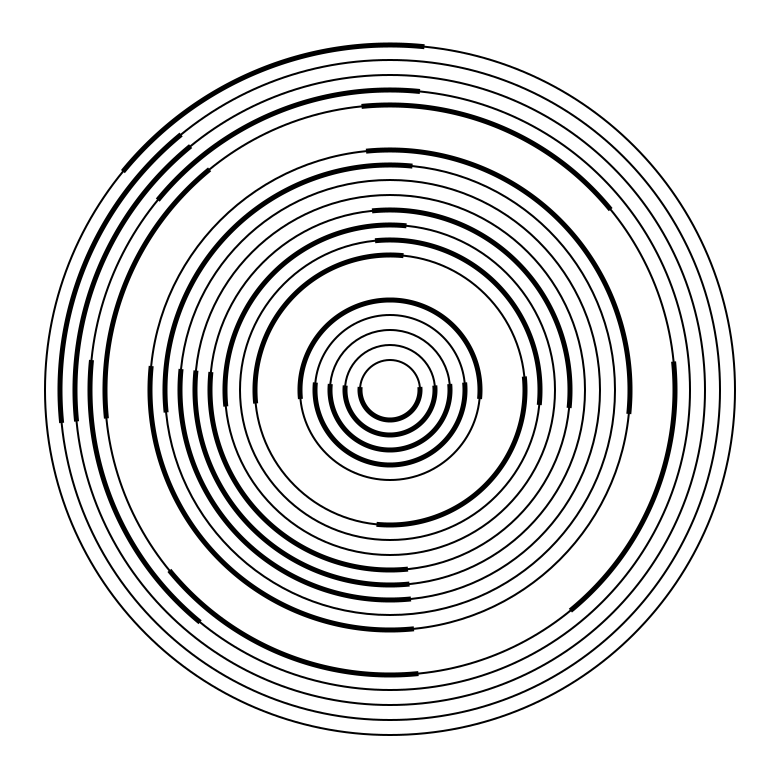

[(60, 0), (100, 0), (140, 0), (180, 1), (260, 3), (320, 2), (340, 3), (420, 1), (460, 1), (500, 1), (520, 2), (540, 3), (600, 1), (740, 5), (820, 3), (840, 4), (880, 4), (900, 5)]


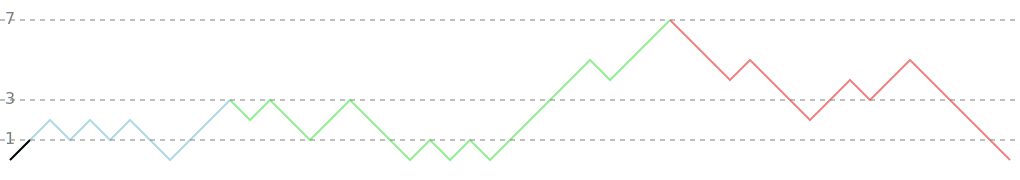

Success! The word is the same: UUDUDUDDUUUDUDDUUDDDUDUDUUUUUDUUUDDDUDDDUUDUUDDDDD


In [ ]:
import copy
def remove_brick(wall, s, n):
    # we are trying to understand if it's possible that s was the latest brick added to the tower
    # for this, it's not enough that it's IN the tower, the way for it must be clear, meaning no s+1 and no s-1 in the way
    # print(f"Trying to remove brick {s} from wall {wall}, num_segments={num_segments}")
    for ring in reversed(wall[1:]): # skip the first ring, it's not touched by add_brick()
        if s in ring:
            ring.remove(s)
            if len(ring) == 0: # if the ring is empty, remove it
                wall.remove(ring)
            return True
        else:
            if (s+1) % n in ring or (s-1) % n in ring:
                return False
    return False

def generate_dyck_from_kepler(tower):
    tower = copy.deepcopy(tower) # we're going to remove bricks
    word = []
    height = 0
    for k in range(len(tower)-1, -1, -1): # go over the walls from last to first
        wall = tower[k]
        current_border = 2**(k+1)-1
        while len(wall) > 1 or height != current_border: # continue until wall is empty except the first ring
            if height == 2*current_border:
                # we're near the next border. we can't reach it, otherwise the tower would have had more walls
                word.append('U')
                height -= 1
            elif height == 0:
                # we're at the bottom, we can't go down anymore
                word.append('D')
                height += 1
            elif height > current_border: # if s_down is in the tower, we made a "down" move, else nothing
                if remove_brick(wall, height - current_border, 2**(k+1)):
                    word.append('D')
                    height += 1
                else:
                    word.append('U')
                    height -= 1
            elif height < current_border: # if s_up is in the tower, we made an "up" move, else nothing
                if remove_brick(wall, height, 2**(k+1)):
                    word.append('U')
                    height -= 1
                else:
                    word.append('D')
                    height += 1
            elif height == current_border:
                # we reached the border either by "down" from above, and then s_down is in the tower, or by "up" from below, and then s_up is in the tower
                # they can't both be in the tower since in this case, s_down = 1 and s_up = current_border + 1, which are adjacent (modulo current_border + 1)
                # print("height == current_border, so we are at the border, trying to remove bricks", s_down, s_up)
                if remove_brick(wall, height - current_border, 2**(k+1)):
                    word.append('D')
                    height += 1
                elif remove_brick(wall, height, 2**(k+1)):
                    word.append('U')
                    height -= 1
                else:
                    raise ValueError("This should not happen")
    word.append('U') # first step is always U
    return ''.join(reversed(word))

word = "UUDUDUDDUUUDUDDUUDDDUDUDUUUUUDUUUDDDUDDDUUDUUDDDDD"
# word = random_dyck_word(6)
# print(word)
#word = "UUDDUD"
tower = generate_kepler_tower_from_dyck(word)
print(tower)
kepler_image = draw_kepler_tower_segmented(tower)
display(SVG(kepler_image.tostring()))
#tower = [[[1], [1], [1], [1], [2]], [[1, 3], [4], [3], [4, 2], [2], [2], [3], [4, 2]], [[1, 3, 5, 7], [6, 4], [5], [5], [6]]]
image = draw_dyck_split(word)
display(SVG(image.tostring()))
#image.saveas("dyck_split.svg")
# tower = generate_kepler_tower_from_dyck(word)
# print(tower)
new_word = generate_dyck_from_kepler(tower)
if word == new_word:
    print("Success! The word is the same:", new_word)
else:
    image = draw_dyck_split(new_word)
    display(SVG(image.tostring()))
    print("Failed! The word is different:", new_word)


In [291]:
towers = generate_kepler_towers(4)
bad_word = "UDUUDDUD"
for tower in towers:
    word = generate_dyck_from_kepler(tower)
    if word == bad_word:
        print("Found a tower that generates the bad word:", tower)

# words = [generate_dyck_from_kepler(tower) for tower in towers]
# for word in words:
#     print(word, words.count(word))
# words = list(set([generate_dyck_from_kepler(tower) for tower in towers]))
# print(len(words))

Found a tower that generates the bad word: [[[1], [2, 1], [2]]]
Found a tower that generates the bad word: [[[1], [2, 1], [2]]]


new: UUDUDUDUUDUUUUUDDDUDUDUUUDDDUUUDUDDDUDDDUUDUUDDDDD
old: UUDUDUDDUUUDUDDUUDDDUDUDUUUUUDUUUDDDUDDDUUDUUDDDDD

In [285]:
for word in generate_dyck_words(7, symbols=('U', 'D')):
    tower = generate_kepler_tower_from_dyck(word)
    new_word = generate_dyck_from_kepler(tower)
    if word != new_word:
        print("Failed! The word is different:", word, new_word)
        image = draw_dyck_split(word)
        display(SVG(image.tostring()))        
        image = draw_dyck_split(new_word)
        display(SVG(image.tostring()))
        

In [ ]:
words = generate_dyck_words(4, symbols=('U', 'D'))

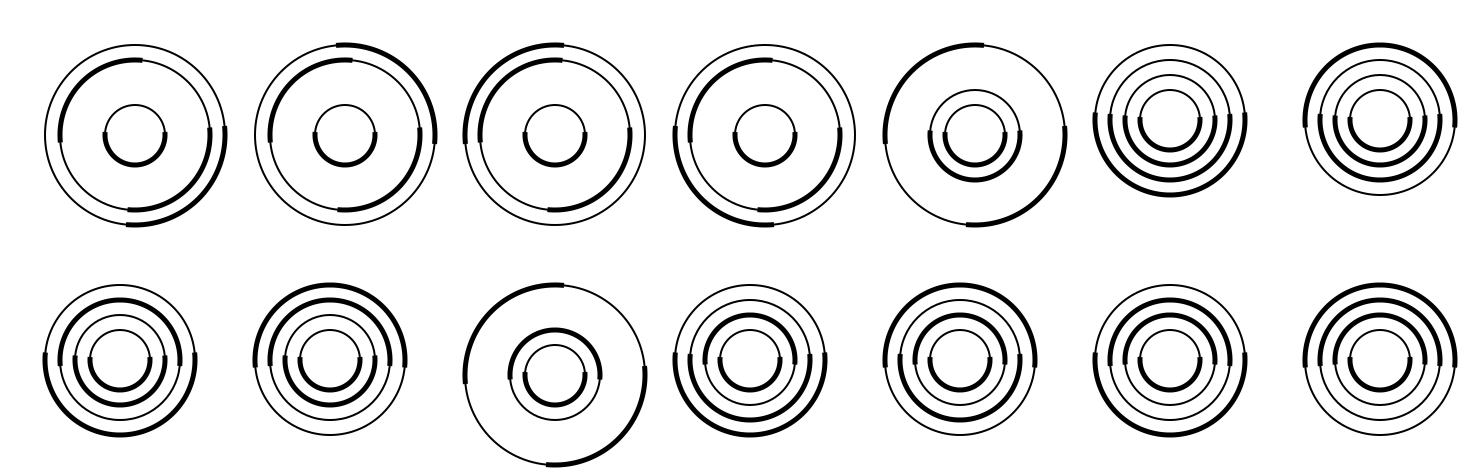

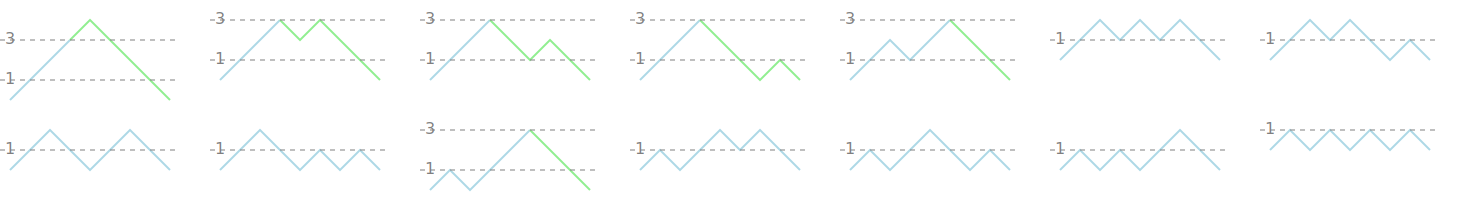

In [201]:
words = generate_dyck_words(4, symbols=('U', 'D'))
towers = [generate_kepler_tower_from_dyck(word) for word in words]
# for word, tower in zip(words,towers):
#     print(f"Word: {word}")
#     image = draw_dyck_split(word)
#     display(SVG(image.tostring()))
#     kepler_image = draw_kepler_tower_segmented(tower)
#     display(SVG(kepler_image.tostring()))
collage = make_collage([draw_kepler_tower_segmented(tower) for tower in towers], cell_width=200, cell_height=230, n_cols=7, margin=10)
display(SVG(collage.tostring()))
words_collage = make_collage([draw_dyck_split(word) for word in words], cell_width=200, cell_height=100, n_cols=7, margin=10)
display(SVG(words_collage.tostring()))
    

This one's good:
UUDUDUDDUUUDUDDUUDDDUDUDUUUUUDUUUDDDUDDDUUDUUDDDDD